# 快速上手 `torchvision.transforms.v2` 

首先，进行一些设置


In [4]:
from pathlib import Path
import torch
from matplotlib import pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import read_image

torch.manual_seed(1)

# If you're trying to run that on collab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
from utils.helpers import plot
img = read_image(str(Path('../assets') / 'astronaut.jpg'))
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 512, 512])


## v2 基础

Torchvision 转换的行为就像常规的 {class}`torch.nn.Module`（事实上，它们中的大多数都是）：实例化转换，传递输入，得到转换后的输出：



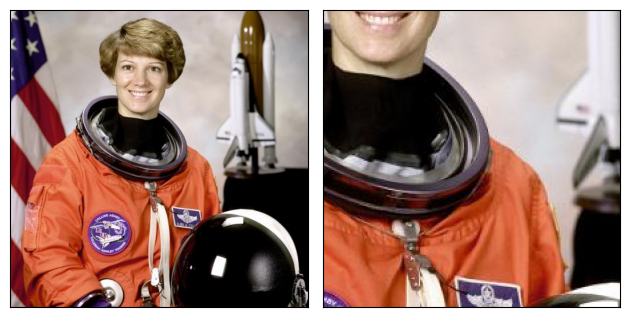

In [5]:
transform = v2.RandomCrop(size=(224, 224))
out = transform(img)

plot([img, out])

## 简单的分类管道



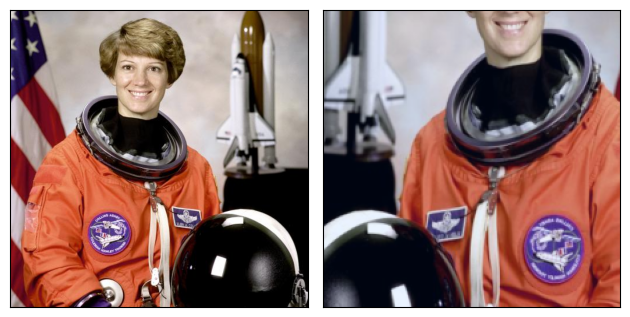

In [6]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
out = transforms(img)

plot([img, out])

这样的转换管道通常作为 `transform` 参数传递给 `Datasets <datasets>`，例如 ``ImageNet(..., transform=transforms)``。

## 检测、分割、视频

`torchvision.transforms.v2` 命名空间中的新的 Torchvision 转换支持图像分类以外的任务：它们还可以转换边界框、分割/检测掩码或视频。

让我们简要地看一下带有边界框的检测示例。

<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>


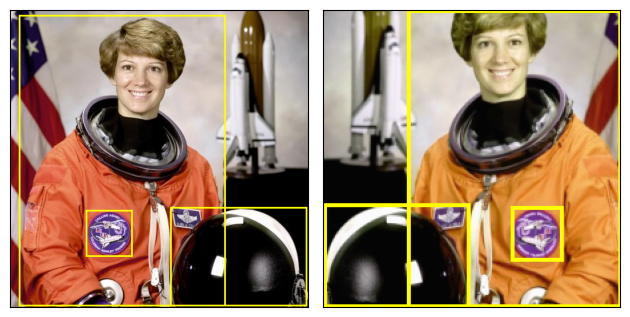

In [7]:
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us

boxes = tv_tensors.BoundingBoxes(
    [
        [15, 10, 370, 510],
        [275, 340, 510, 510],
        [130, 345, 210, 425]
    ],
    format="XYXY", canvas_size=img.shape[-2:])

transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
])
out_img, out_boxes = transforms(img, boxes)
print(type(boxes), type(out_boxes))

plot([(img, boxes), (out_img, out_boxes)])

上述示例主要关注目标检测。但是，如果我们有用于对象分割或语义分割的掩码（{class}`torchvision.tv_tensors.Mask`）或视频（{class}`torchvision.tv_tensors.Video`），我们可以以完全相同的方式将它们传递给转换。

现在您可能有几个问题：这些 TVTensors 是什么，我们如何使用它们，以及这些转换的预期输入/输出是什么？我们将在下一节中回答这些问题。

## TVTensors 是什么？

TVTensors 是 {class}`torch.Tensor` 子类，可得到 {class}`~torchvision.tv_tensors.Image`、{class}`~torchvision.tv_tensors.BoundingBoxes`、{class}`~torchvision.tv_tensors.Mask` 和 {class}`~torchvision.tv_tensors.Video`。

TVTensors 看起来和感觉就像普通的张量一样 - 它们就是张量。像 ``.sum()`` 或任何 ``torch.*`` 算子这样的普通 {class}`torch.Tensor` 支持的所有内容也将在 TVTensor 上工作：

In [8]:
img_dp = tv_tensors.Image(torch.randint(0, 256, (3, 256, 256), dtype=torch.uint8))

print(f"{isinstance(img_dp, torch.Tensor) = }")
print(f"{img_dp.dtype = }, {img_dp.shape = }, {img_dp.sum() = }")

isinstance(img_dp, torch.Tensor) = True
img_dp.dtype = torch.uint8, img_dp.shape = torch.Size([3, 256, 256]), img_dp.sum() = tensor(25087958)


这些 TVTensor 类是转换的核心：为了转换给定的输入，转换首先查看对象的类，并相应地分派到适当的实现。

在这个阶段，您不需要了解更多关于 TVTensors 的知识，但希望了解更多的高级用户可以参考 [TVTensors FAQ](https://pytorch.org/vision/stable/auto_examples/transforms/plot_tv_tensors.html#sphx-glr-auto-examples-transforms-plot-tv-tensors-py)。

## 需要传递什么作为输入？

在上面，我们看到了两个示例：一个将单个图像作为输入，即 `out = transforms(img)`，另一个同时传递了图像和边界框，即 ``out_img, out_boxes = transforms(img, boxes)``。

实际上，转换支持任意输入结构。输入可以是单个图像、元组、任意嵌套的字典...几乎任何东西。相同的结构将作为输出返回。下面，我们使用相同的检测转换，但将元组（图像，目标字典）作为输入，并获得与输出相同的结构：

('arbitrary', {'structure': '!'})


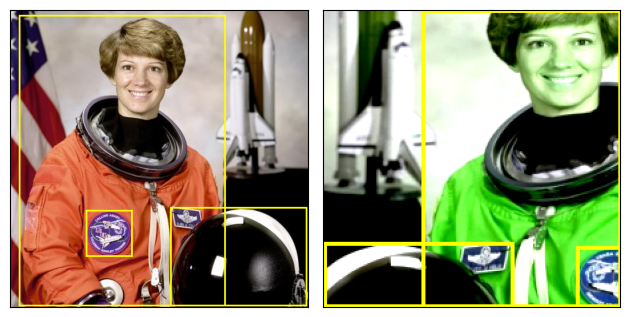

In [9]:
target = {
    "boxes": boxes,
    "labels": torch.arange(boxes.shape[0]),
    "this_is_ignored": ("arbitrary", {"structure": "!"})
}

# Re-using the transforms and definitions from above.
out_img, out_target = transforms(img, target)

plot([(img, target["boxes"]), (out_img, out_target["boxes"])])
print(f"{out_target['this_is_ignored']}")

我们传递了一个元组，所以我们得到了一个元组作为输出，第二个元素是转换后的目标字典。转换并不真正关心输入的结构；如上所述，它们只关心对象的类型并相应地进行转换。

对于像字符串或整数这样的外部对象，它们会原样传递。这在调试时可能会很有用，例如，如果你想为每个样本关联一个路径！

## 转换和数据集的兼容性

粗略地说，数据集的输出必须与转换的输入相对应。如何做到这一点取决于您是使用 torchvision 内置的数据集还是自己的自定义数据集。

### 内置的数据集

如果您只是进行图像分类，则无需执行任何操作。只需使用数据集的 `transform` 参数，例如 ``ImageNet(..., transform=transforms)``，然后就可以开始了。

Torchvision 还支持像 {class}`torchvision.datasets.CocoDetection` 这样的目标检测或分割数据集。这些数据集比 {mod}`torchvision.transforms.v2` 模块和 TVTensors 更早出现，因此它们不会自动返回 TVTensors。强制使这些数据集返回 TVTensors 并使它们与 v2 转换兼容的简单方法是使用 {func}`torchvision.datasets.wrap_dataset_for_transforms_v2` 函数：

```python
from torchvision.datasets import CocoDetection, wrap_dataset_for_transforms_v2

dataset = CocoDetection(..., transforms=my_transforms)
dataset = wrap_dataset_for_transforms_v2(dataset)
# Now the dataset returns TVTensors!
```
